In [48]:
import json
import numpy as np
from pathlib import Path
import sys
import os
import yaml
import pandas as pd
import pickle

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc
import scipy
import io 

from IPython import embed


# ---------------------------- LOADING FUNCTIONS ----------------------------

def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



def calcAction(p0,tw,ele,exn=2.5e-6,nrj=7000e9,debug=False):
    ex = exn*0.938e9/nrj
    alfx = tw.rows[ele].cols['alfx'].alfx[0]
    alfy = tw.rows[ele].cols['alfy'].alfy[0]
    betx = tw.rows[ele].cols['betx'].betx[0]
    bety = tw.rows[ele].cols['bety'].bety[0]
    xx0 = tw.rows[ele].cols['x'].x[0]
    yy0 = tw.rows[ele].cols['y'].y[0]
    pxx0 = tw.rows[ele].cols['px'].px[0]
    pyy0 = tw.rows[ele].cols['py'].py[0]
    x0 = p0.x - xx0
    y0 = p0.y - yy0
    px0 = p0.px - pxx0
    py0 = p0.py - pyy0
    jx = np.sqrt(x0**2/betx + (alfx*x0/np.sqrt(betx) + np.sqrt(betx)*px0)**2)/np.sqrt(ex)
    jy = np.sqrt(y0**2/bety + (alfy*y0/np.sqrt(bety) + np.sqrt(bety)*py0)**2)/np.sqrt(ex)

    if debug:
        print(tw.rows[ele].cols[['alfx','alfy','betx','bety','x','y','px','py']])
    return jx,jy

def plotHist(p1,p2,figdim=(20,10), nbins=200, save=False, savePath="plot", line = None, density=False,scale=1, range=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,figsize=figdim)
    ax.hist([p1*scale,p2*scale],nbins,density=density,color=['red','green'])
    if line is not None:
        if not hasattr(line, '__iter__') or isinstance(line, str):
            line = [line]
        for l in line:
            ax.axvline(x=l, color='black', linestyle='--')

    if range is not None:
        ax.set_xlim(range)
    plt.show()

def get_df_to_save(dict, num_particles, num_turns, epsilon = 0, start = False, x_dim = None, y_dim = None, jaw_L = None):

    float_variables = ['zeta', 'x', 'px', 'y', 'py', 'delta', 'p0c']
    int_variables = ['at_turn', 'particle_id', 'at_element', 'state', 'parent_particle_id']
    variables = float_variables + int_variables
    variables.remove('at_element')

    df = pd.DataFrame(dict['data'])
    var_dict = {}

    for var in variables:
        new_arr = np.array(df[var])
        new_arr = new_arr.reshape((num_particles, num_turns))
        var_dict[var] = new_arr   
    del df

    
    impact_part_dict = {}
    for key in var_dict.keys():
        impact_part_dict[key] = []

    if x_dim is not None and jaw_L is not None and y_dim is not None:

        abs_y_low = jaw_L
        abs_y_up = jaw_L + y_dim
        abs_x_low = -x_dim/2
        abs_x_up = x_dim/2

        print('x_dim', x_dim, 'y_dim', y_dim, 'jaw_L', jaw_L, num_particles, num_turns)
        for part in range(num_particles):
            for turn in range(num_turns):
                if var_dict['state'][part, turn] > 0 and var_dict['x'][part, turn] > (abs_x_low - epsilon) and var_dict['x'][part, turn] < (abs_x_up + epsilon) and var_dict['y'][part, turn] > (abs_y_low - epsilon) and var_dict['y'][part, turn] < (abs_y_up + epsilon):
                    for key in var_dict.keys():
                        impact_part_dict[key].append(var_dict[key][part, turn])

    impact_part_df = pd.DataFrame(impact_part_dict) 
    
    return impact_part_df




# -------------------------------------------------------------------------------




beam          = 2
plane         = 'V'

num_turns     = 1 #run_dict['turns'] 
num_particles = 1000000 #len(start_values)

normalized_emittance = 2.5e-6


TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TCP_name = 'tcp.d6r7.b2'

TCCS_align_angle_step = 0



coll_file = os.path.expandvars('${HOME_TWOCRYST}/input_files/colldbs/HL_tight_twocryst.yaml')




if coll_file.endswith('.yaml'):
    with open(coll_file, 'r') as stream:
        coll_dict = yaml.safe_load(stream)['collimators']['b2']
if coll_file.endswith('.data'):
    print("Please convert and use the yaml file for the collimator settings")
    sys.exit(1)
    


context = xo.ContextCpu(omp_num_threads='auto')



# ---------------------------- SETUP LINE ----------------------------
def setup_line(line_name, coll_dict=coll_dict, beam = 2, plane = 'V', num_particles = num_particles, num_turns = 1, TCCS_align_angle_step=0):

    TCCS_align_angle_step = 0
    TCCS_gap =  7.2 #7.2
    TARGET_gap = 33.6 #33.6
    TCCP_gap =  33.6 #33.6
    PIXEL_gap = 33.6  #33.6

    mode = 'target_absorber'
    turn_on_cavities = True
    engine        = 'everest'


    # Load from json
    line_file = os.path.expandvars(line_name)
    line = xt.Line.from_json(line_file)

    end_s = line.get_length()

    TCCS_name = 'tccs.5r3.b2'
    TCCP_name = 'tccp.4l3.b2'
    TARGET_name = 'target.4l3.b2'
    PIXEL_name = 'pixel.detector'
    TCP_name = 'tcp.d6r7.b2'

    d_pix = 1 # [m]
    ydim_PIXEL = 0.01408
    xdim_PIXEL = 0.04246

    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    dx = 1e-11
    TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2 + dx)
    PIXEL_loc = end_s - (6653.3 - coll_dict[TCCP_name]["length"]/2 - d_pix)
    TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]

    print('TARGET LOC: ', end_s - TARGET_loc)
    print('TCP LOC: ', end_s - TCP_loc)
    print('TCLA LOC: ', end_s -   line.get_s_position()[line.element_names.index('tcla.a5l3.b2')])


    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
    line.insert_element(at_s=PIXEL_loc, element=xt.Marker(), name=PIXEL_name)


    TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TCCP_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    PIXEL_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TCP_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    #dx = 1e-11
    line.insert_element(at_s = TCCS_loc - coll_dict[TCCS_name]["length"]/2 - dx, element=TCCS_monitor, name='TCCS_monitor')
    line.insert_element(at_s = TARGET_loc - coll_dict[TARGET_name]["length"]/2 - dx, element=TARGET_monitor, name='TARGET_monitor')
    line.insert_element(at_s = TCCP_loc - coll_dict[TCCP_name]["length"]/2 - dx/2, element=TCCP_monitor, name='TCCP_monitor')
    line.insert_element(at_s = PIXEL_loc, element=PIXEL_monitor, name='PIXEL_monitor')
    line.insert_element(at_s = TCP_loc + coll_dict[TCP_name]["length"]/2 + 1e5*dx, element=TCP_monitor, name='TCP_monitor') 

    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])

    # switch on cavities
    if turn_on_cavities:
        speed = line.particle_ref._xobject.beta0[0]*scipy.constants.c
        harmonic_number = 35640
        voltage = 12e6/len(line.get_elements_of_type(xt.Cavity)[1])
        frequency = harmonic_number * speed /line.get_length()
        for side in ['l', 'r']:
            for cell in ['a','b','c','d']:
                line[f'acsca.{cell}5{side}4.b2'].voltage = voltage
                line[f'acsca.{cell}5{side}4.b2'].frequency = frequency   

    # Aperture model check
    print('\nAperture model check on imported model:')
    df_imported = line.check_aperture()
    assert not np.any(df_imported.has_aperture_problem)


    # Initialise collmanager
    coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)

    # Install collimators into line
    if engine == 'everest':
        coll_names = coll_manager.collimator_names

        if mode == 'target_absorber': 
            black_absorbers = [TARGET_name,]
        else: 
            black_absorbers = []

        everest_colls = [name for name in coll_names if name not in black_absorbers]

        coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
        coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)
    else:
        raise ValueError(f"Unknown scattering engine {engine}!")


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

    coll_manager.build_tracker()
    coll_manager.set_openings(gaps = {TCCS_name: TCCS_gap, TCCP_name: TCCP_gap, TARGET_name: TARGET_gap})


    print("\nTCCS aligned to beam: ", line[TCCS_name].align_angle)
    #line[TTCS_name].align_angle = TTCS_align_angle_step
    print("TCCS align angle incremented by step: ", TCCS_align_angle_step)
    line[TCCS_name].align_angle = line[TCCS_name].align_angle + TCCS_align_angle_step
    print("TCCS final alignment angle: ", line[TCCS_name].align_angle)


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

    return line, coll_manager







# ---------------------------- LOAD PARTICLES ----------------------------


def select_particle(n_job = 0, part_id = 0, return_both = True):

    load_input_path = '/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7____20240319-1209'
    #load_input_path = '/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7___20240319-0931'
    input_path  = Path(load_input_path, f'Job.{n_job}/Outputdata/particles_B{beam}{plane}.h5')
    print('Particles read from: ', input_path)

    df_part = pd.read_hdf(input_path, key='initial_particles')
    dct_part = df_part.to_dict(orient='list')
    size_vars = (
        (xo.Int64, '_capacity'),
        (xo.Int64, '_num_active_particles'),
        (xo.Int64, '_num_lost_particles'),
        (xo.Int64, 'start_tracking_at_element'),
    )
    scalar_vars = (
            (xo.Float64, 'q0'),
            (xo.Float64, 'mass0'),
            (xo.Float64, 't_sim'),
        )
    for tt, nn in scalar_vars + size_vars:
        if nn in dct_part.keys() and not np.isscalar(dct_part[nn]):
                dct_part[nn] = dct_part[nn][0]
    part = xp.Particles.from_dict(dct_part, load_rng_state=True)

    p = part.filter(part.particle_id==part_id)

    if return_both:
        return p, part
    else:
        return p



part, part_job = select_particle(n_job = 99, part_id = 81904, return_both = True)

# ---------------------------- DECIDE LINES TO TRACK ----------------------------
line0_file = '${HOME_TWOCRYST}/input_files/HL_IR7_tune_changed/b4_sequence_patched_tune.json'
line1_file = '${HOME_TWOCRYST}/input_files/HL_IR7_phase_advance/b4_sequence_patched_phadv.json'

line0, coll_manager0 = setup_line(line0_file, coll_dict)
#line1, coll_manager1 = setup_line(line1_file)


# ---------------------------- GET SOME  INFRMATION ----------------------------

idx_TCP = line0.element_names.index(TCP_name)
idx_TARGET = line0.element_names.index(TARGET_name)
idx_TCCS = line0.element_names.index(TCCS_name)


# ---------------------------- TRACKING ----------------------------
part_gen = part.copy()
idx = line0.element_names.index(TCP_name)



def plot_traj(s_part, y_part, line):
    import matplotlib.pyplot as plt
    
    if not hasattr(s_part, '__iter__') or isinstance(s_part, list):
        if any(isinstance(subvar, list) for subvar in s_part):
            pass
        else:
            s_part = [s_part]
            y_part = [y_part]
    for s, y in zip(s_part,y_part):
        plt.plot(s,y)
    plt.vlines(line.get_s_elements()[idx_TCCS], -0.015, 0.015, color='k', linestyles='--')
    plt.vlines(line.get_s_elements()[idx_TARGET], -0.015, 0.015,color='k', linestyles='--')
    plt.vlines(line.get_s_elements()[idx_TCP], -0.015, 0.015,color='k', linestyles='--')
    
    plt.hlines(line.elements[idx_TCCS].jaw_L + line.elements[idx_TCCS].ref_y, line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    plt.hlines(line.elements[idx_TCCS].jaw_L + line.elements[idx_TCCS].ref_y  + coll_dict[TCCS_name]['xdim'], line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    plt.hlines(line.elements[idx_TARGET].jaw_L + line.elements[idx_TARGET].ref_y, line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    plt.hlines(line.elements[idx_TARGET].jaw_L + line.elements[idx_TARGET].ref_y  + coll_dict[TARGET_name]['xdim'], line.get_s_elements()[idx_TCCS], line.get_s_elements()[idx_TARGET], color='b', linestyles='--')
    ips = ['ip1', 'ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8']
    for ip in ips:
        plt.vlines( line.get_s_position()[ line.element_names.index(ip)], -0.015, 0.015,color='r', linestyles='--', alpha=0.3)
        plt.text(line.get_s_position()[line.element_names.index(ip)], 0.02, ip)

    plt.show()



def save_y_traj(line, part, idx_start, idx_stop):
    s, y= [], []
    for i in range(idx_start,idx_stop):
        line.track(part, ele_start=i, ele_stop=i+1)
        s.append(part.s[0])
        y.append(part.y[0])
    return s, y

def save_y_multiturn(line, part, idx_start, num_turns):

    def save_y_traj(line, part, idx_start, idx_stop):
        s, y= [], []
        for i in range(idx_start,idx_stop):
            line.track(part, ele_start=i, ele_stop=i+1)
            s.append(part.s[0])
            y.append(part.y[0])
        return s, y

    ss, yy = [], []
    s, y= [],[]
    final_idx = len(line.element_names)
    s, y = save_y_traj(line, part, idx_start, final_idx)
    ss.append(s[:-1])
    yy.append(y[: -1])
    t = 1
    while t < num_turns:
        s, y = save_y_traj(line, part, 0, final_idx)
        ss.append(s[:-1])
        yy.append(y[:-1])
        t = t+1
    return ss, yy

def track_turns(line, part, num_turns, idx_start = None):
    if idx_start is not None:
        line.track(part, num_turns=num_turns, ele_start=idx_start)
    else:
        line.track(part, num_turns=num_turns)

Particles read from:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7____20240319-1209/Job.99/Outputdata/particles_B2V.h5


Loading line from dict:   0%|          | 0/151124 [00:00<?, ?it/s]

Done loading line from dict.           
TARGET LOC:  6653.337500000009
TCP LOC:  20199.140373184753
TCLA LOC:  6574.220795520017
Bad apertures :  {}
Replace bad apertures with Marker

Aperture model check on imported model:


Checking aperture:   0%|          | 0/151143 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tccs.5r3.b2          as EverestCrystal
Installing tccp.4l3.b2          as EverestCrystal
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tclpx.4l1.b2         as EverestCollimator
Installing tcl.5l1.b2           as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tctph.4r2.b2         as EverestCollimator
Installing tctpv.4r2.b2         as EverestCollimator
Installing tdisa.a4r8.b2        as EverestCollimator
Installing tdisb.a4r8.b2        as EverestCollimator
Installing tdisc.a4r8.b2        as EverestCollimator
Installing tclia.4r2            as EverestCollimator
Installing tclib.6l8.b2         as EverestCollimator
Installing tcld.a11l2.b2        as EverestCollimator
Installing tcp.6r3.b2

Checking aperture:   0%|          | 0/150687 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Compiling ContextCpu kernels...


d526094bf15145f1a327fa08ae2e7f1e.c: In function 'BlackAbsorber_track_local_particle':
d526094bf15145f1a327fa08ae2e7f1e.c:16562:16: warning: unused variable 's_collimator' [-Wunused-variable]
16562 |         double s_collimator = LocalParticle_get_s(part);
      |                ^~~~~~~~~~~~


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)



TCCS aligned to beam:  -1.4117913840472246e-05
TCCS align angle incremented by step:  0
TCCS final alignment angle:  -1.4117913840472246e-05

Aperture model check after introducing collimators:


Checking aperture:   0%|          | 0/150687 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


: 

In [2]:
tw = line0.twiss()

In [4]:
import matplotlib.pyplot as plt

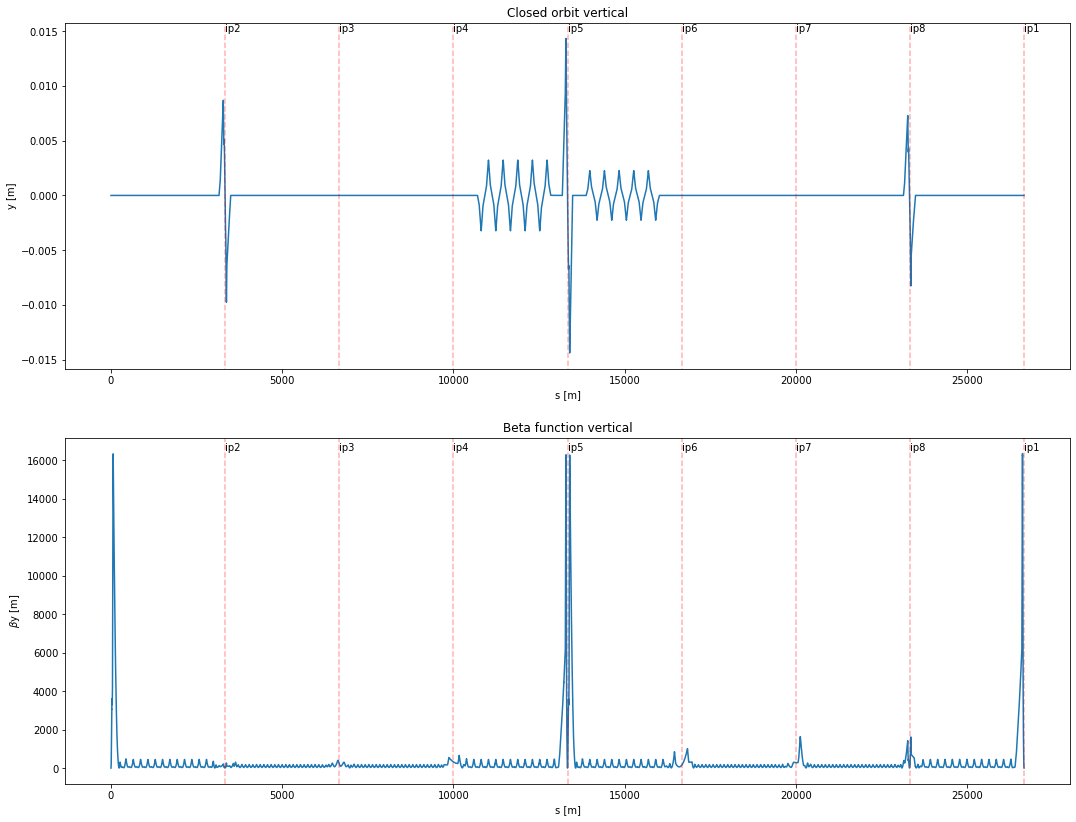

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(18,14))
end_s = line0.get_length()
ax[0].plot(end_s - tw.s, tw.y, label='y')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('y [m]')
ips = ['ip1', 'ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8']
for ip in ips:
    ax[0].axvline( end_s - line0.get_s_position()[ line0.element_names.index(ip)], -0.015, 15,color='r', linestyle='--', alpha=0.3)
    ax[0].text(end_s - line0.get_s_position()[line0.element_names.index(ip)], 0.015, ip)
ax[0].set_title('Closed orbit vertical')

ax[1].plot(end_s - tw.s, tw.bety, label='y')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel(r'$\beta$y [m]')
ips = ['ip1', 'ip2', 'ip3', 'ip4', 'ip5', 'ip6', 'ip7', 'ip8']
for ip in ips:
    ax[1].axvline( end_s - line0.get_s_position()[ line0.element_names.index(ip)], 0, 16500, color='r', linestyle='--', alpha=0.3)
    ax[1].text(end_s - line0.get_s_position()[line0.element_names.index(ip)], 16500, ip)
ax[1].set_title('Beta function vertical')
plt.savefig('./Plots/HL_startingline.png')

In [45]:
plt.savefig('./Plots/HL_startingline.png')

<Figure size 432x288 with 0 Axes>